In [285]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as pd

In [286]:
# compute different time for each link

def compute_t0(x, v_auto=60, v_hailing=40, v_transit=30): # minutes
    """comupute free flow time for different modes

    Args:
        x ([pd.DataFrame]): [link info]
        v_auto (int, optional): [auto speed]. Defaults to 60.
        v_hailing (int, optional): [ride-hailing speed]. Defaults to 40.
        v_transit (int, optional): [transit speed]. Defaults to 30.

    Returns:
        [pd.Series]: [t_0]
    """

    if x['attribute'] == 'auto':
        return (x['l_a'] / v_auto) * 60
    
    elif x['attribute'] == 'ride-hailing':
        return (x['l_a'] / v_hailing) *60
    
    elif x['attribute'] == 'transit':
        return (x['l_a'] / v_transit)*60
    
    elif x['attribute'] == 'P&R':
        return 5

    else:
        return 0

def compute_travel_time(x):
    """compute the travel time

    Args:
        x ([pd.DataFrame]): [link info]

    Returns:
        [pd.Series]: [travel time]
    """
    
    if x['attribute'] in ['auto', 'P&R']:
        return x['t_0'] * (1 + 0.15 * (x['flow'] / x['c_a']) ** 4) # BPR function

    elif x['attribute'] == 'transit':
        return x['t_0'] * x['f_bus']/x['f_bus'] # compute travel time based on bus frequency 

    else:
        return x['t_0'] # the travel time for other modes is same as the free flow time

def compute_walk_time(x, v_walk=5.6):
    """compute_walk_time

    Args:
        x ([pd.DataFrame]): [link info]
        v_walk (float, optional): [walk speed]. Defaults to 5.6.

    Returns:
        [pd.Series]: [walk speed]
    """
    
    if x['attribute'] in ['transit-transfer', 'board_transit']: #by bus or bus transfer 
        return (x['l_a'] / v_walk) * 60

    elif x['attribute'] in ['board_ride-hailing', 'R&T']: # by ride-hailing
        return 3
    
    elif x['attribute'] in ['P&R']: # auto transfer bus
        return 5
    
    else: # other modes
        return 0

def compute_wait_time(x, n_idle):
    """compute_wait_time

    Args:
        x ([pd.DataFrame]): [link info]
        n_idle ([int]): [the number of idle ride-hailing vehicles]

    Returns:
        [pd.Series]: [wait time]
    """

    if x['attribute'] in ['transit-transfer','P&R','R&T','board_transit']:
        return 60 / x['f_bus']
    
    elif x['attribute'] in ['board_ride-hailing']:
        A = 2 # waiting time coefficient 
        return (A / (1 + n_idle**0.5)) * 60
    
    else:
        return 0

def compute_congesition_time(x):
    """compute_congesition_time for transit link

    Args:
        x ([pd.DataFrame]): [link info]

    Returns:
        [pd.Series]: [congestion time]
    """

    if x['attribute'] in ['transit']:
        return  60 * (0.5 * x['flow'] / (120 * x['f_bus']))**3
    
    else:
        return 0

def compute_penalty(x, penalty=12):
    """add a transfer penalty for transfer link

    Args:
        x ([pd.DataFrame]): [link info]
        penalty (int, optional): [transfer penalty]. Defaults to 12.

    Returns:
        [pd.Series]: [transfer penalty]
    """

    if x['attribute'] in ['transit-transfer','P&R','R&T']:
        return penalty
    
    else:
        return 0

def compute_lamda_0_auto(fuel_consumption=6.46, driving_speed=50, fuel_price=9.2):
    """compute_lamda_0_auto: compute auto fare rate for auto link

    Args:
        fuel_consumption (float, optional): [fuel consumuption per 100 km]. Defaults to 6.46.
        driving_speed (int, optional): [average auto speed]. Defaults to 50.
        fuel_price (float, optional): [fuel price]. Defaults to 9.2.

    Returns:
        [int]: [fare rate: RMB/h]
    """

    lamda_0_auto = round((fuel_consumption / 100 * fuel_price * driving_speed)/ 60, 2) # unit: min/h, fare rate for auto
    return lamda_0_auto

def compute_fare(x,lamda_0_auto, lamda_0_hailing, lamda_0_PR, miu_out):
    """compute fare for each link

    Args:
        x ([pd.DataFrame]): [link info]
        lamda_0_hailing ([int]): [fare rate for ride-hailing service]
        lamda_0_PR ([int]): [park charge for P&R]

    Returns:
        [pd.Series]: [computed_fare]
    """

    if x['attribute'] in ['auto']:
        return lamda_0_auto * (x['travel'])
    
    elif x['attribute'] == 'ride-hailing':
        return lamda_0_hailing * x['travel']
    
    elif x['attribute'] == 'P&R':
        return (lamda_0_PR /miu_out) * 60 # 应该除以VOT, 单位: minute
    
    else:
        return 0

def compute_link_time(link_table, n_idle, lamda_0_auto, lamda_0_hailing, lamda_0_PR, miu_out):
    """compute link time

    Args:
        link_table ([pd.DataFrame]): [link info]
        n_idle ([int]): [idle ride-hailing vehiles]
        lamda_0_auto ([int]): [fare rate for auto link]
        lamda_0_hailing ([int]): [fare rate for ride-hailing link]
        lamda_0_PR ([int]): [fare rate for P&R link]

    Returns:
        [type]: [description]
    """
    
    link_table['t_0'] = link_table.apply(compute_t0, axis = 1)
    link_table['travel'] = link_table.apply(compute_travel_time, axis = 1)
    link_table['fare_rate'] = link_table.apply(compute_fare, 
                                               lamda_0_hailing=lamda_0_hailing, 
                                               lamda_0_PR=lamda_0_PR,
                                               lamda_0_auto=lamda_0_auto,
                                               miu_out = miu_out,
                                               axis = 1)
    link_table['walk'] = link_table.apply(compute_walk_time, axis = 1)
    link_table['wait'] = link_table.apply(compute_wait_time, n_idle = n_idle, axis = 1)
    link_table['congestion'] = link_table.apply(compute_congesition_time, axis = 1)
    link_table['penalty'] = link_table.apply(compute_penalty, axis = 1)

    return link_table


# generate a Graph
import networkx as nx
def get_graph(link_table, node_table):
    """
    generate a network based on link information and node information
    input: link_table and node table
    output: a graph

    Args:
        link_table ([pd.DataFrame]): [link table]
        node_table ([pd.DataFrame]): [node table]

    Returns:
        [graph]: [a graph for network]
    """

    # add eages from link table 
    G = nx.from_pandas_edgelist(df = link_table, 
                            edge_key= "link_id",
                            source = "from", 
                            target = "to", 
                            edge_attr=['name','link_id','type', 'attribute', 'c_a', 'l_a', 't_0','travel', 'fare_rate', 'f_bus', 
                            'walk', 'wait', 'congestion', 'penalty'], 
                            create_using=nx.MultiDiGraph())

    # add node attributes                       
    node_attributes = node_table.set_index('name').to_dict('index') # generate a node attributes dictionary 
    nx.set_node_attributes(G, node_attributes)

    return G

"""generate path set and compute path cost 
"""

import networkx as nx
import pandas as pd
import math

# generate a pathset
def get_path_set(G, origin_zone, destination_zone):
    """
    generate a path set and compute path attributes (O_node, D_node, links, cost, path flow, prob, logit_prob, y_flow) 

    Args:
        G ([graph]): [network]
        origin_zone ([list]): [list of origin zones]
        destination_zone ([list]): [list of destination zones]
        theta_1 ([float]): [parameter of logit model for path choice]
        
    Returns:
        [pd.DataFrame]: [path set]
    """

    # initialize a paths set
    paths = []
    for i in origin_zone:
        for j in destination_zone:
            for path in nx.all_simple_edge_paths(G, source= i, target= j): # generate all paths 
                od_pair = i +'-'+ j # record origin zone and destination zone
                links = path # record links
                link_sque =[G.edges[edge]['link_id'] for edge in path] # record links ID
                name_sque = [G.edges[edge]['name'] for edge in path]
                attribute_set = [G.edges[edge]['attribute'] for edge in path]
                path_length = sum(G.edges[edge]['l_a'] for edge in path) # compute length for each path
                path_travel = sum(G.edges[edge]['travel'] for edge in path) 
                path_fare = sum(G.edges[edge]['fare_rate'] for edge in path) 
                path_walk = sum(G.edges[edge]['walk'] for edge in path) 
                path_wait = sum(G.edges[edge]['wait'] for edge in path)
                path_congestion = sum(G.edges[edge]['congestion'] for edge in path)
                path_penalty = sum(G.edges[edge]['penalty'] for edge in path) # compute travel cost for each path 
                #path_flow = 0 #min(G.edges[edge]['flow'] for edge in path) # compute path flow for each path (link flow of one path is the same)               
                paths.append([od_pair, links, link_sque, name_sque, attribute_set, path_length, path_travel, 
                              path_walk, path_wait, path_congestion, path_penalty, path_fare])

    # generate a path information table based pandas DataFrame
    path_set = pd.DataFrame(paths, columns = ['OD_pair', 'links','link_sque','name_sque','attribute_set','path_length',
                                              'path_travel','path_walk','path_wait','path_congestion','path_penalty','path_fare'])
    
    # map travel mode
    def map_mode(x):
        if x['attribute_set'] in [['board_auto', 'auto', 'alight_auto']]:
            return 'auto'
        elif x['attribute_set'] in [['board_transit', 'transit', 'alight_transit'],
                                    ['board_transit', 'transit', 'transit-transfer', 'alight_transit']]:
            return 'transit'
        elif x['attribute_set'] in [['board_auto', 'auto', 'P&R', 'transit', 'alight_transit']]:
            return 'P&R'
        elif x['attribute_set'] in [['board_ride-hailing', 'ride-hailing', 'R&T', 'transit', 'alight_transit'],
                                    ['board_ride-hailing', 'ride-hailing', 'R&T', 'transit', 'transit-transfer', 'alight_transit']]:
            return 'R&T'
        else:
            return 'other'
    
    # clean links
    def get_links(x):
        return [i[:2] for i in x['links']]
    
    path_set['attribute_set'] = path_set['attribute_set'].apply(lambda x: sorted(set(x),key=x.index))
    path_set['links'] = path_set.apply(get_links, axis=1)
    path_set['mode'] = path_set.apply(map_mode, axis=1)
    # add a path_id field
    path_set['path_id'] = range(1, len(path_set)+1)
    path_set['path_id'] = 'path' + '-' + path_set['path_id'].astype('str')

    return path_set[path_set['mode'].isin(['auto', 'P&R','transit', 'R&T'])]

#######################################################################################

def cost_func(x, miu_in, miu_out, lamda_0_transit):
    """compute path cost

    Args:
        x ([pd.DataFrame]): [path info]
        miu_in (int, optional): [in-vahile VOT]. Defaults to 2.
        miu_out (int, optional): [out-vahile VOT]. Defaults to 3.
        lamda_0_transit (int, optional): [transit ticket]. Defaults to 3.

    Returns:
        [pd.Series]: [path cost]
    """
    cost = miu_in / 60 * (x['path_travel'] + x['path_congestion']) + miu_out / 60 * (x['path_walk']+ x['path_wait'] + x['path_penalty']) + x['path_fare']

    if x['mode'] in ['auto']:
        return -cost
        
    elif x['mode'] in ['transit', 'P&R', 'R&T']:
        return -(cost + lamda_0_transit)

def cost_exp(x, theta_1):
    """compute cost exp

    Args:
        x ([pd.DataFrame]): [path info]
        theta_1 (float, optional): [logit parameter in path level]. Defaults to 0.1.

    Returns:
        [type]: [description]
    """
    return  math.exp(theta_1 * x['path_cost'] / 100)

def path_cost(path_set, miu_in, miu_out, lamda_0_transit, theta_1):
    """path_set after computing path cost

    Args:
        path_set ([pd.DataFrame]): [path info]

    Returns:
        [pd.DataFrame]: [path set with path cost]
    """
    path_set['path_cost'] = path_set.apply(cost_func, miu_in=miu_in, miu_out=miu_out, lamda_0_transit=lamda_0_transit, axis=1)
    path_set['path_exp'] = path_set.apply(cost_exp, theta_1=theta_1, axis=1)
    path_set['path_duration'] = path_set['path_travel'] + path_set['path_walk'] + path_set['path_wait'] + path_set['path_congestion']
    path_set = path_set[['OD_pair', 'path_id', 'links', 'link_sque', 'name_sque', 'attribute_set','path_length',
                         'mode', 'path_duration','path_cost', 'path_exp']]
    return path_set

"""compute mode possbility 
"""
import math
import pandas as pd

def get_mode_set(paths, theta_1, theta_2):
    """generate a mode set for the netwerork and calculate the mode choice probability.

    Args:
        paths ([pd.DataFrame]): [path set]
        theta_1 ([float]): [logit parameter for path]
        theta_2 ([float]): [logit parameter for mode]

    Returns:
        [pd.DataFrame]: [mode set information]
    """

    # computing the log-sum term for mode
    def get_log_sum(x):
        return (1/theta_1) * math.log(sum(x)+1)
    
    mode_set = pd.DataFrame(paths.groupby(by=['mode'], as_index=False)['path_exp'].apply(get_log_sum))
    mode_set.columns =['mode', 'path_logsum']

    # computing the negative unity term
    mode_set['exp_logsum'] = theta_2 * mode_set['path_logsum']
    mode_set['mode_logit'] = mode_set['exp_logsum'].apply(math.exp) / mode_set['exp_logsum'].apply(math.exp).sum()

    return mode_set

####################################################################################################################
def get_y_flow(mode_set, path_set, demand):
    """
    computing y_flow based on nested logit model
    Args:
        mode_set ([pd.DataFrame]): [mode set]
        path_set ([pd.DataFrame]): [path set]
        demand ([pd.DataFrame]): [trip demand between origin and destination]

    Returns:
        [pd.DataFrame]: [path set after computing 'y_flow' and 'path_prob']
    """

    # compute logit probability for path
    def logit_prob(x):
        return x / sum(x)
    
    # generate mode probability dictionary and demand dictionary
    mode_prob_dict = {mode_set['mode'][i] : mode_set['mode_logit'][i] for i in range(len(mode_set))}
    demand_dict = {demand['OD_pair'][i]:demand['demand'][i] for i in range(len(demand))}
    
    # map mode probability and demand to paths
    path_set['mode_logit'] = path_set['mode'].map(mode_prob_dict)
    path_set['demand'] = path_set['OD_pair'].map(demand_dict)
    
    # compute the mode flow
    path_set['mode_flow'] = path_set['demand'] * path_set['mode_logit']

    # compute logit probability for path
    path_set['path_logit'] = path_set.groupby(by=['mode'], as_index=False)['path_exp'].transform(logit_prob)

    # compute based-logit-probability flow (mode_flow * logit_prob_path)
    path_set['y_flow'] = path_set['mode_flow'] * path_set['path_logit']

    # compute based-flow probability
    #path_set['path_prob'] = path_set['path_flow'] / path_set['mode_flow']

    return path_set[['OD_pair','demand', 'path_id', 'name_sque','attribute_set', 'path_length','path_duration','path_cost',
                    'mode','mode_logit','mode_flow','path_logit','y_flow']]

"""path flow to link flow 
"""
def update_link_flow(path_set, link_table):
    """
    1. generate a link set based on path set after traffic assignment
    2. merge the path flow on the same link by the same mode
    3. generate a link flow dictionary
    4. map the link flow to the link table before traffic assignment

    Args:
        path_set ([pd.DataFrame]): [path set after comuting y_flow]
        link_lable ([pd.DataFrame]): [link table]

    Returns:
        [pd.DataFrame]: [link table after updating link flow]
    """

    # explode according to the name_sque
    path_to_link = path_set.explode('name_sque', ignore_index=True)
    path_to_link = path_to_link[['name_sque', 'mode', 'path_flow']]

    # generate a dictionary of link_name and path_flow
    path_to_link = path_to_link.groupby(by=['name_sque'], as_index=False).sum()
    path_flow_dict = {path_to_link['name_sque'][i]:path_to_link['path_flow'][i] for i in range(len(path_to_link))}

    #link_flow_dict = {link_table['name'][i]:link_table['flow'][i] for i in range(len(link_table))}
    #link_flow_dict |= path_flow_dict # update original flow
    # update original flow
    link_flow_dict = {link_table['name'][i]: link_table['flow'][i]for i in range(len(link_table))} | path_flow_dict

    # map path_flow to original links table
    link_table['flow'] = link_table['name'].map(link_flow_dict)
    return link_table

"""
comupute idle ride-hailing vehiles 
"""

def compute_idle_vehile(link_table, N_hailing):
    """
    computing idle ride-hailing vehicles based on conservation equation
    conservation equation: N_ride-hailing = n_idle + q_comb (travel_time + waiting_hailing) 

    Args:
        link_table ([pd.DataFrame]): [link table after assigning flow]
        N_hailing ([int]): [all ride-hailing vehiles in the network]

    Returns:
        [int]: [idle ride-hailing vehiles]
    """
    hailing_link = link_table[link_table['attribute'].isin(['board_ride-hailing','ride-hailing'])]
    occupied_hailing = ((hailing_link['travel'] + hailing_link['walk'] +hailing_link['wait']) /60 * hailing_link['flow']).sum()
    return max(N_hailing-occupied_hailing, 0)

In [287]:
my_link = pd.read_excel('../input_network/Nguyen_Dupuis_network.xlsx', sheet_name='link_info')
my_node = pd.read_excel('../input_network/Nguyen_Dupuis_network.xlsx', sheet_name='node_info')
my_link['name'] = my_link['from'].astype('str') +'-'+my_link['to'].astype('str')
my_demand = pd.read_excel('../input_network/Nguyen_Dupuis_network.xlsx', sheet_name='demand_info')

In [288]:
# parameters
N_hailing = 500
lamda_0_hailing = 2
lamda_0_PR = 10
miu_in = 20
miu_out = 15
theta_1=1
theta_2= 0.5 
# theta_3=1
lamda_0_transit=3

In [289]:
# initialization
# 1. initializing link time of different link type
my_link_set = compute_link_time(link_table=my_link,
                    n_idle=N_hailing,
                    lamda_0_auto=compute_lamda_0_auto(),
                    lamda_0_hailing=lamda_0_hailing,
                    lamda_0_PR=lamda_0_PR,
                    miu_out=miu_out
                    )
# add initial iteration number
my_link_set['I'] = 0

In [290]:
# 2. initializing path set
    # 2.1 generate graph
my_graph = get_graph(link_table=my_link_set, node_table=my_node)
    # 2.2 generate path set
my_path_set = get_path_set(G=my_graph, origin_zone=['r1'], destination_zone=['s1'])
my_path_set = path_cost(path_set=my_path_set,miu_in=miu_in, miu_out=miu_out, lamda_0_transit=lamda_0_transit, theta_1=theta_1)
    # 2.3 initializing path flow
my_path_set['path_flow'] = my_demand['demand'].sum() / len(my_path_set) # average assignment
my_path_set['I'] = 0 # add initial iteration number

In [291]:
my_path_set

,OD_pair,path_id,links,link_sque,name_sque,attribute_set,path_length,mode,path_duration,path_cost,path_exp,path_flow,I
0,r1-s1,path-1,"[(r1, N3), (N3, N4), (N4, N1), (N1, N2), (N2, ...","[43, 5, 2, 1, 3, 7, 8, 13, 44]","[r1-N3, N3-N4, N4-N1, N1-N2, N2-N5, N5-N6, N6-...","[board_auto, auto, alight_auto]",21.0,auto,21.000000,-17.500000,0.839457,66.666667,0
1,r1-s1,path-2,"[(r1, N3), (N3, N4), (N4, N1), (N1, N2), (N2, ...","[43, 5, 2, 1, 3, 7, 12, 16, 44]","[r1-N3, N3-N4, N4-N1, N1-N2, N2-N5, N5-N6, N6-...","[board_auto, auto, alight_auto]",21.0,auto,21.000000,-17.500000,0.839457,66.666667,0
2,r1-s1,path-3,"[(r1, N3), (N3, N4), (N4, N1), (N1, N2), (N2, ...","[43, 5, 2, 1, 3, 7, 12, 18, 20, 44]","[r1-N3, N3-N4, N4-N1, N1-N2, N2-N5, N5-N6, N6-...","[board_auto, auto, alight_auto]",26.0,auto,26.000000,-21.666667,0.805198,66.666667,0
3,r1-s1,path-4,"[(r1, N3), (N3, N4), (N4, N1), (N1, N2), (N2, ...","[43, 5, 2, 1, 3, 11, 15, 16, 44]","[r1-N3, N3-N4, N4-N1, N1-N2, N2-N5, N5-N9, N9-...","[board_auto, auto, alight_auto]",21.0,auto,21.000000,-17.500000,0.839457,66.666667,0
4,r1-s1,path-5,"[(r1, N3), (N3, N4), (N4, N1), (N1, N2), (N2, ...","[43, 5, 2, 1, 3, 11, 15, 18, 20, 44]","[r1-N3, N3-N4, N4-N1, N1-N2, N2-N5, N5-N9, N9-...","[board_auto, auto, alight_auto]",26.0,auto,26.000000,-21.666667,0.805198,66.666667,0
5,r1-s1,path-6,"[(r1, N3), (N3, N4), (N4, N1), (N1, N2), (N2, ...","[43, 5, 2, 1, 3, 38, 31, 32, 34, 47]","[r1-N3, N3-N4, N4-N1, N1-N2, N2-N5, N5-N22, N2...","[board_auto, auto, P&R, transit, alight_transit]",22.0,P&R,46.000000,-66.416667,0.514702,66.666667,0
7,r1-s1,path-8,"[(r1, N3), (N3, N4), (N4, N1), (N1, N2), (N2, ...","[43, 5, 2, 1, 4, 13, 44]","[r1-N3, N3-N4, N4-N1, N1-N2, N2-N7, N7-N11, N1...","[board_auto, auto, alight_auto]",19.0,auto,19.000000,-15.833333,0.853565,66.666667,0
8,r1-s1,path-9,"[(r1, N3), (N3, N4), (N4, N5), (N5, N6), (N6, ...","[43, 5, 6, 7, 8, 13, 44]","[r1-N3, N3-N4, N4-N5, N5-N6, N6-N7, N7-N11, N1...","[board_auto, auto, alight_auto]",15.0,auto,15.000000,-12.500000,0.882497,66.666667,0
9,r1-s1,path-10,"[(r1, N3), (N3, N4), (N4, N5), (N5, N6), (N6, ...","[43, 5, 6, 7, 12, 16, 44]","[r1-N3, N3-N4, N4-N5, N5-N6, N6-N10, N10-N11, ...","[board_auto, auto, alight_auto]",15.0,auto,15.000000,-12.500000,0.882497,66.666667,0
10,r1-s1,path-11,"[(r1, N3), (N3, N4), (N4, N5), (N5, N6), (N6, ...","[43, 5, 6, 7, 12, 18, 20, 44]","[r1-N3, N3-N4, N4-N5, N5-N6, N6-N10, N10-N13, ...","[board_auto, auto, alight_auto]",20.0,auto,20.000000,-16.666667,0.846482,66.666667,0


In [292]:
# 3. initializing mode set
my_mode_set = get_mode_set(paths=my_path_set, theta_1=theta_1,theta_2=theta_2)
# add initial iteration number
my_mode_set['I'] = 0

In [293]:
# path flow
new_paths = get_y_flow(mode_set=my_mode_set,path_set=my_path_set, demand=my_demand)
# add initial iteration number
new_paths['I'] = 0
new_paths['path_flow'] = my_path_set['path_flow']
new_paths.head(10)

,OD_pair,demand,path_id,name_sque,attribute_set,path_length,path_duration,path_cost,mode,mode_logit,mode_flow,path_logit,y_flow,I,path_flow
0,r1-s1,2000,path-1,"[r1-N3, N3-N4, N4-N1, N1-N2, N2-N5, N5-N6, N6-...","[board_auto, auto, alight_auto]",21.0,21.0,-17.500000,auto,0.400641,801.282198,0.057999,46.473369,0,66.666667
1,r1-s1,2000,path-2,"[r1-N3, N3-N4, N4-N1, N1-N2, N2-N5, N5-N6, N6-...","[board_auto, auto, alight_auto]",21.0,21.0,-17.500000,auto,0.400641,801.282198,0.057999,46.473369,0,66.666667
2,r1-s1,2000,path-3,"[r1-N3, N3-N4, N4-N1, N1-N2, N2-N5, N5-N6, N6-...","[board_auto, auto, alight_auto]",26.0,26.0,-21.666667,auto,0.400641,801.282198,0.055632,44.576766,0,66.666667
3,r1-s1,2000,path-4,"[r1-N3, N3-N4, N4-N1, N1-N2, N2-N5, N5-N9, N9-...","[board_auto, auto, alight_auto]",21.0,21.0,-17.500000,auto,0.400641,801.282198,0.057999,46.473369,0,66.666667
4,r1-s1,2000,path-5,"[r1-N3, N3-N4, N4-N1, N1-N2, N2-N5, N5-N9, N9-...","[board_auto, auto, alight_auto]",26.0,26.0,-21.666667,auto,0.400641,801.282198,0.055632,44.576766,0,66.666667
5,r1-s1,2000,path-6,"[r1-N3, N3-N4, N4-N1, N1-N2, N2-N5, N5-N22, N2...","[board_auto, auto, P&R, transit, alight_transit]",22.0,46.0,-66.416667,P&R,0.179246,358.491139,0.245414,87.978876,0,66.666667
7,r1-s1,2000,path-8,"[r1-N3, N3-N4, N4-N1, N1-N2, N2-N7, N7-N11, N1...","[board_auto, auto, alight_auto]",19.0,19.0,-15.833333,auto,0.400641,801.282198,0.058974,47.254416,0,66.666667
8,r1-s1,2000,path-9,"[r1-N3, N3-N4, N4-N5, N5-N6, N6-N7, N7-N11, N1...","[board_auto, auto, alight_auto]",15.0,15.0,-12.500000,auto,0.400641,801.282198,0.060972,48.856110,0,66.666667
9,r1-s1,2000,path-10,"[r1-N3, N3-N4, N4-N5, N5-N6, N6-N10, N10-N11, ...","[board_auto, auto, alight_auto]",15.0,15.0,-12.500000,auto,0.400641,801.282198,0.060972,48.856110,0,66.666667
10,r1-s1,2000,path-11,"[r1-N3, N3-N4, N4-N5, N5-N6, N6-N10, N10-N13, ...","[board_auto, auto, alight_auto]",20.0,20.0,-16.666667,auto,0.400641,801.282198,0.058484,46.862265,0,66.666667


In [294]:
from sklearn.metrics import mean_squared_error

# 2.iteration
import numpy as np
maximum_iter = 100
acceptable_gap = 0.00001
MSE = mean_squared_error(new_paths['path_flow'].values, new_paths['y_flow'].values)
RMSE = np.sqrt(MSE)

# 1. initialize a list to store the result of each iteration
iteration = []
res_link_flow = my_link_set.copy()
res_path_flow = new_paths.copy()
res_path_set = my_path_set.copy()
res_mode_set = my_mode_set.copy()
idle_ride_hailing = [[0, N_hailing]]

# 2.iteration
for I in range(1, maximum_iter+1):
    # 2.1 cheak the convergence
    #print(new_paths['path_flow'].values)
    MSE = mean_squared_error(new_paths['path_flow'].values, new_paths['y_flow'].values)
    RMSE = np.sqrt(MSE)

    if RMSE < acceptable_gap:
        break

    # 2.2 update path flow
    new_paths['path_flow'] = new_paths['path_flow'] + (1 / I) * (new_paths['y_flow'] - new_paths['path_flow'])
    path_flow = new_paths['path_flow'].values
    #print(f'path_flow:{path_flow}')

    # 2.3 update link flow
    my_link_set = update_link_flow(path_set=new_paths, link_table=my_link_set)

    # 2.4 comute idle ride-hailing vehicle number
    n_idle_hailing = compute_idle_vehile(link_table=my_link,N_hailing=N_hailing)
    print(n_idle_hailing)

    # 2.5 update link cost
    my_link_set = compute_link_time(link_table=my_link_set,
                    n_idle=n_idle_hailing,
                    lamda_0_auto=compute_lamda_0_auto(),
                    lamda_0_hailing=lamda_0_hailing,
                    lamda_0_PR=lamda_0_PR,
                    miu_out=miu_out)

     # 2.6 add iteration number in link_set
    my_link_set['I'] = I 

    # 2.7 re-generate graph
    my_graph = get_graph(link_table=my_link_set, node_table=my_node)

    # 2.8 re-generate path set
    my_path_set = get_path_set(G=my_graph, origin_zone=['r1'], destination_zone=['s1'])
    my_path_set = path_cost(path_set=my_path_set,miu_in=miu_in, miu_out=miu_out, lamda_0_transit=lamda_0_transit, theta_1=theta_1)
    my_path_set['I'] = I # add initial iteration number

    # 2.9 re-generate mode set
    my_mode_set = get_mode_set(paths=my_path_set, theta_1=theta_1,theta_2=theta_2)

    # 2.10 add iteration number in mode_set
    my_mode_set['I'] = I
    
    # 2.11 re-generate y_flow
    new_paths = get_y_flow(mode_set=my_mode_set,path_set=my_path_set, demand=my_demand)
    new_paths['path_flow'] = path_flow
    #print(new_paths['y_flow'].values)
    # add initial iteration number
    new_paths['I'] = I

    # 2.13 store the result of each iteration
        # 2.13.1 iteration number and gap
    iteration.append([I, RMSE])
        # 2.13.2 link_set
    res_link_flow = pd.concat([res_link_flow, my_link_set], ignore_index=True)
        # 2.13.3 path_set
    res_path_set = pd.concat([res_path_set, my_path_set], ignore_index=True)
    res_path_flow = pd.concat([res_path_flow, new_paths], ignore_index=True)
        # 2.13.4 mode_set
    res_mode_set = pd.concat([res_mode_set, my_mode_set], ignore_index=True)

        # 2.13.5 n_idle
    idle_ride_hailing.append([I, n_idle_hailing])

    print('Iteration = {0}, gap = {1},'.format(I,RMSE))

# 3. transform the iteration to dataframe
iteration = pd.DataFrame(iteration, columns=['I', 'RMSE'])
idle_ride_hailing = pd.DataFrame(idle_ride_hailing, columns=['I', 'n_idle'])

    #return my_link_set, my_path_set, my_mode_set, my_graph, iteration, idle_ride_hailing, res_link_flow, res_path_flow, res_mode_set

372.2112822739645
Iteration = 1, gap = 26.197648419934744,
365.20010947790956
Iteration = 2, gap = 2.1769047432671815,
364.4764604078261
Iteration = 3, gap = 0.8631774479284101,
364.28762579604825
Iteration = 4, gap = 0.5213687971084529,
364.19256131805776
Iteration = 5, gap = 0.36754061690532663,
364.1327017333482
Iteration = 6, gap = 0.28114290187906776,
364.09133809802
Iteration = 7, gap = 0.22623440028390887,
364.06107664425025
Iteration = 8, gap = 0.18845166958095988,
364.03801044940707
Iteration = 9, gap = 0.16096720920758797,
364.01986919681974
Iteration = 10, gap = 0.14013480964978273,
364.0052433554325
Iteration = 11, gap = 0.12383628124011906,
363.99321213531664
Iteration = 12, gap = 0.11075996039035844,
363.98314898670276
Iteration = 13, gap = 0.10005178208433754,
363.9746130460501
Iteration = 14, gap = 0.09113260749220839,
363.96728527631575
Iteration = 15, gap = 0.08359634691365463,
363.96092922592356
Iteration = 16, gap = 0.077150126775766,
363.95536601196807
Iteration = 

In [295]:
for i in range(9):
    print(res_path_flow[res_path_flow['I'] == i]['path_flow'].sum())

2000.0000000000005
2000.0
2000.0000000000002
2000.0
2000.0000000000002
1999.9999999999998
1999.9999999999995
2000.0000000000002
2000.0


In [296]:
idle_ride_hailing

,I,n_idle
0,0,500.000000
1,1,372.211282
2,2,365.200109
3,3,364.476460
4,4,364.287626
...,...,...
96,96,363.887521
97,97,363.887388
98,98,363.887257
99,99,363.887130


In [297]:
iteration

,I,RMSE
0,1,26.197648
1,2,2.176905
2,3,0.863177
3,4,0.521369
4,5,0.367541
...,...,...
95,96,0.009319
96,97,0.009210
97,98,0.009103
98,99,0.008998


In [300]:
res_path_set

,OD_pair,path_id,links,link_sque,name_sque,attribute_set,path_length,mode,path_duration,path_cost,path_exp,path_flow,I,mode_logit,demand,mode_flow,path_logit,y_flow
0,r1-s1,path-1,"[(r1, N3), (N3, N4), (N4, N1), (N1, N2), (N2, ...","[43, 5, 2, 1, 3, 7, 8, 13, 44]","[r1-N3, N3-N4, N4-N1, N1-N2, N2-N5, N5-N6, N6-...","[board_auto, auto, alight_auto]",21.0,auto,21.000000,-17.500000,0.839457,66.666667,0,0.400641,2000,801.282198,0.057999,46.473369
1,r1-s1,path-2,"[(r1, N3), (N3, N4), (N4, N1), (N1, N2), (N2, ...","[43, 5, 2, 1, 3, 7, 12, 16, 44]","[r1-N3, N3-N4, N4-N1, N1-N2, N2-N5, N5-N6, N6-...","[board_auto, auto, alight_auto]",21.0,auto,21.000000,-17.500000,0.839457,66.666667,0,0.400641,2000,801.282198,0.057999,46.473369
2,r1-s1,path-3,"[(r1, N3), (N3, N4), (N4, N1), (N1, N2), (N2, ...","[43, 5, 2, 1, 3, 7, 12, 18, 20, 44]","[r1-N3, N3-N4, N4-N1, N1-N2, N2-N5, N5-N6, N6-...","[board_auto, auto, alight_auto]",26.0,auto,26.000000,-21.666667,0.805198,66.666667,0,0.400641,2000,801.282198,0.055632,44.576766
3,r1-s1,path-4,"[(r1, N3), (N3, N4), (N4, N1), (N1, N2), (N2, ...","[43, 5, 2, 1, 3, 11, 15, 16, 44]","[r1-N3, N3-N4, N4-N1, N1-N2, N2-N5, N5-N9, N9-...","[board_auto, auto, alight_auto]",21.0,auto,21.000000,-17.500000,0.839457,66.666667,0,0.400641,2000,801.282198,0.057999,46.473369
4,r1-s1,path-5,"[(r1, N3), (N3, N4), (N4, N1), (N1, N2), (N2, ...","[43, 5, 2, 1, 3, 11, 15, 18, 20, 44]","[r1-N3, N3-N4, N4-N1, N1-N2, N2-N5, N5-N9, N9-...","[board_auto, auto, alight_auto]",26.0,auto,26.000000,-21.666667,0.805198,66.666667,0,0.400641,2000,801.282198,0.055632,44.576766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3025,r1-s1,path-29,"[(r1, N16), (N16, N17), (N17, N18), (N18, N22)...","[48, 24, 25, 41, 31, 32, 34, 47]","[r1-N16, N16-N17, N17-N18, N18-N22, N22-N23, N...","[board_ride-hailing, ride-hailing, R&T, transi...",15.0,R&T,46.974791,-38.160152,0.682767,NaN,100,0.232127,2000,464.254494,0.169872,78.863741
3026,r1-s1,path-31,"[(r1, N16), (N16, N17), (N17, N19), (N19, N25)...","[48, 24, 27, 42, 35, 37, 36, 47]","[r1-N16, N16-N17, N17-N19, N19-N25, N25-N27, N...","[board_ride-hailing, ride-hailing, R&T, transi...",20.0,R&T,53.790156,-40.598607,0.666319,NaN,100,0.232127,2000,464.254494,0.165780,76.963942
3027,r1-s1,path-32,"[(r1, N16), (N16, N17), (N17, N21), (N21, N22)...","[48, 24, 40, 30, 31, 32, 34, 47]","[r1-N16, N16-N17, N17-N21, N21-N22, N22-N23, N...","[board_ride-hailing, ride-hailing, R&T, transi...",15.0,R&T,48.807393,-29.771019,0.742516,NaN,100,0.232127,2000,464.254494,0.184737,85.765163
3028,r1-s1,path-33,"[(r1, N16), (N16, N17), (N17, N21), (N21, N22)...","[48, 24, 40, 30, 33, 37, 36, 47]","[r1-N16, N16-N17, N17-N21, N21-N22, N22-N27, N...","[board_ride-hailing, ride-hailing, R&T, transi...",14.5,R&T,56.950081,-34.538820,0.707945,NaN,100,0.232127,2000,464.254494,0.176136,81.772000


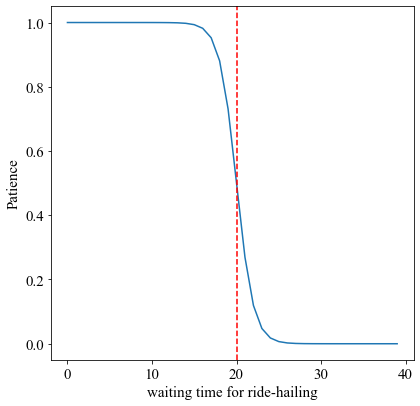

In [299]:
import matplotlib.pyplot as plt
x = np.arange(0, 40, 1)
y = 1 - 1/(1+ np.exp(20-x))

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 15

plt.figure(figsize=(6.5,6.5))
ax = plt.subplot(111)
ax.plot(x,y)

ax.set_xlabel('waiting time for ride-hailing')
ax.set_ylabel('Patience')
ax.axvline(x=20, ymin=0, ymax=1, ls='--', color = 'red')


plt.show()